In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [306]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0, 1/3,40)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
# γ3_list_test = γ3_list[[0,1,2,-1]]
# γ3_list = γ3_list_test

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [5]:
from multiprocessing import Pool
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [6]:
args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
solution_low = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

episode: 5000,	 ode error: 3.79047342763672e-05,	 ft error: 4.192191606833262e-05


In [8]:
args_list = []
for y_tilde in jump_interval:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 5000, 1e-7, 0.5)
        args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        
#         ϕ, ems, _, _ = solve_smooth_100()
#         ϕ_list.append(ϕ)
#         e_list.append(ems)
#     ϕ_list = np.array(ϕ_list)
#     e_list = np.array(e_list)
#     res_list.append((ϕ_list, e_list))

In [9]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 2433,	 ode error: 0.00025184937058989054,	 ft error: 9.978877801852803e-08
episode: 2679,	 ode error: 0.000549758824288045,	 ft error: 9.981084758692305e-08
episode: 2683,	 ode error: 0.000564088258230934,	 ft error: 9.960132274500211e-08
episode: 2501,	 ode error: 0.00023304680467108735,	 ft error: 9.994464678086956e-08
episode: 2675,	 ode error: 0.0005351792552360582,	 ft error: 9.992848681861233e-08
episode: 2602,	 ode error: 0.00032573422613314806,	 ft error: 9.991067084769156e-08
episode: 2543,	 ode error: 0.0002796782636365347,	 ft error: 9.981685167304022e-08
episode: 2550,	 ode error: 0.0002949205380490816,	 ft error: 9.982420223764166e-08
episode: 2657,	 ode error: 0.00047785931163019796,	 ft error: 9.963242852961685e-08
episode: 2651,	 ode error: 0.000456930580036978,	 ft error: 9.984824878017662e-08
episode: 2572,	 ode error: 0.00032501690017415485,	 ft error: 9.98656730644143e-08
episode: 2637,	 ode error: 0.00041004303785057566,	 ft error: 9.99529259360088e-08
epi

episode: 2690,	 ode error: 0.0005838439244426827,	 ft error: 9.989997451498311e-08
episode: 2573,	 ode error: 0.00032316452969276266,	 ft error: 9.975319859023557e-08
episode: 2502,	 ode error: 0.0002318122575455453,	 ft error: 9.979813420102346e-08
episode: 5000,	 ode error: 0.00016440640830168995,	 ft error: 1.1822971808683747e-05
episode: 2662,	 ode error: 0.0004949818274607651,	 ft error: 9.973214432079658e-08
episode: 2717,	 ode error: 0.0006893630521324808,	 ft error: 9.997565619812576e-08
episode: 2729,	 ode error: 0.0007272802492153604,	 ft error: 9.996836070058635e-08
episode: 2652,	 ode error: 0.00045626507927308546,	 ft error: 9.958284863387235e-08
episode: 2719,	 ode error: 0.0007013946950625051,	 ft error: 9.981271453796126e-08
episode: 2696,	 ode error: 0.0006108013057689321,	 ft error: 9.977779136249865e-08
episode: 2657,	 ode error: 0.0004763334574123604,	 ft error: 9.978807469224193e-08
episode: 2693,	 ode error: 0.0005973854069804135,	 ft error: 9.988358407042597e-08


episode: 2725,	 ode error: 0.0007284060302342119,	 ft error: 9.99116416267043e-08
episode: 2709,	 ode error: 0.0006668320764106131,	 ft error: 9.984113269467798e-08
episode: 2724,	 ode error: 0.0007168010516223171,	 ft error: 9.96929667707036e-08
episode: 2438,	 ode error: 0.00025495877249750304,	 ft error: 9.960753211135653e-08
episode: 2735,	 ode error: 0.0007534415281890278,	 ft error: 9.96646711826088e-08
episode: 2700,	 ode error: 0.0006154311547792064,	 ft error: 9.9806246822709e-08
episode: 2645,	 ode error: 0.00043434139557343987,	 ft error: 9.956053226289896e-08
episode: 2644,	 ode error: 0.00043427693132339074,	 ft error: 9.993525829088412e-08
episode: 2703,	 ode error: 0.0006284356821142992,	 ft error: 9.95466749031948e-08
episode: 2727,	 ode error: 0.0007399585005781993,	 ft error: 9.959738989095968e-08
episode: 2675,	 ode error: 0.0005394895473012015,	 ft error: 9.972245429423765e-08
episode: 2721,	 ode error: 0.0006933834881893593,	 ft error: 9.963980751592771e-08
episode

episode: 2725,	 ode error: 0.0007677028577970438,	 ft error: 9.98412552632999e-08
episode: 2541,	 ode error: 0.0002843753868878307,	 ft error: 9.986749782697757e-08
episode: 2500,	 ode error: 0.00023750111043212285,	 ft error: 9.956875102190565e-08
episode: 5000,	 ode error: 0.00033260113195678065,	 ft error: 1.7533248285239722e-05
episode: 2678,	 ode error: 0.0005647205326426569,	 ft error: 9.97050673134936e-08
episode: 2635,	 ode error: 0.00040891531685666865,	 ft error: 9.992310090467527e-08
episode: 2705,	 ode error: 0.0006699371270376397,	 ft error: 9.961439495498325e-08
episode: 2725,	 ode error: 0.0007713618773757466,	 ft error: 9.957095059576204e-08
episode: 2681,	 ode error: 0.0005803128888608837,	 ft error: 9.989290106204862e-08
episode: 2720,	 ode error: 0.0007163348477939452,	 ft error: 9.982798587770958e-08
episode: 2643,	 ode error: 0.0004337266999215328,	 ft error: 9.980645465645921e-08
episode: 2721,	 ode error: 0.0007315280789669011,	 ft error: 9.980441895152126e-08
ep

episode: 2696,	 ode error: 0.0006483818828868573,	 ft error: 9.968609404609197e-08
episode: 2726,	 ode error: 0.0007458404935626294,	 ft error: 9.95366704614753e-08
episode: 2715,	 ode error: 0.0007276453482097482,	 ft error: 9.970652392610191e-08
episode: 2685,	 ode error: 0.0005885196989926789,	 ft error: 9.972964853943722e-08
episode: 2574,	 ode error: 0.0002948104456246825,	 ft error: 9.962045499634087e-08
episode: 2712,	 ode error: 0.0006986363830589343,	 ft error: 9.973685166642099e-08
episode: 2614,	 ode error: 0.0003543936655209731,	 ft error: 9.969097458650822e-08
episode: 2710,	 ode error: 0.0006858966712728724,	 ft error: 9.981144266646425e-08
episode: 2670,	 ode error: 0.0005374919607056931,	 ft error: 9.98208271596468e-08
episode: 2656,	 ode error: 0.00047902055993743337,	 ft error: 9.98602089907763e-08
episode: 2625,	 ode error: 0.0003818534607506127,	 ft error: 9.957199775811887e-08
episode: 2727,	 ode error: 0.0007575517980378289,	 ft error: 9.968260883397306e-08
episod

episode: 2704,	 ode error: 0.0006800183490753529,	 ft error: 9.954348456631124e-08
episode: 2701,	 ode error: 0.000666524399644125,	 ft error: 9.995006067242684e-08
episode: 2635,	 ode error: 0.00040855624123033174,	 ft error: 9.96249696072482e-08
episode: 2661,	 ode error: 0.0005005361355763516,	 ft error: 9.965762792774058e-08
episode: 2684,	 ode error: 0.0005997729780710358,	 ft error: 9.988729843257715e-08
episode: 2643,	 ode error: 0.00043340661860793994,	 ft error: 9.95397950731558e-08
episode: 2426,	 ode error: 0.00018579786272920895,	 ft error: 9.986424454044851e-08
episode: 2670,	 ode error: 0.0005345787272435822,	 ft error: 9.990574767471117e-08
episode: 5000,	 ode error: 0.00016289087796129975,	 ft error: 1.2986093586242475e-05
episode: 2719,	 ode error: 0.0007259772991213172,	 ft error: 9.951252444295733e-08
episode: 2541,	 ode error: 0.00028576901742861927,	 ft error: 9.956849567060999e-08
episode: 2600,	 ode error: 0.00032517681861869707,	 ft error: 9.978690318490635e-08


episode: 2641,	 ode error: 0.00043236744476652517,	 ft error: 9.981859960817019e-08
episode: 2539,	 ode error: 0.0002893619683579443,	 ft error: 9.977087112034155e-08
episode: 2705,	 ode error: 0.0007106849596671266,	 ft error: 9.953129342932243e-08
episode: 2684,	 ode error: 0.0006095453742827051,	 ft error: 9.982032800337493e-08
episode: 2654,	 ode error: 0.0004784871454712944,	 ft error: 9.974831627346248e-08
episode: 2582,	 ode error: 0.00029378670037442933,	 ft error: 9.978773540808561e-08
episode: 2718,	 ode error: 0.0007571219449925524,	 ft error: 9.95400881720343e-08
episode: 2648,	 ode error: 0.000456065477542969,	 ft error: 9.97911886457814e-08
episode: 2701,	 ode error: 0.0006730638300524831,	 ft error: 9.965766878394788e-08
episode: 2633,	 ode error: 0.0004077564909082468,	 ft error: 9.99917215693813e-08
episode: 2634,	 ode error: 0.0004079681026109838,	 ft error: 9.964889358116125e-08
episode: 2716,	 ode error: 0.0007404031850147472,	 ft error: 9.999806671601164e-08
episod

episode: 2687,	 ode error: 0.0006192051946061067,	 ft error: 9.982827009480388e-08
episode: 2711,	 ode error: 0.0007412089813242199,	 ft error: 9.963889979758278e-08
episode: 2707,	 ode error: 0.0007104541307409694,	 ft error: 9.989857119307999e-08
episode: 2669,	 ode error: 0.0005411194192717905,	 ft error: 9.99605678231319e-08
episode: 2665,	 ode error: 0.0005212386062805156,	 ft error: 9.982840154521e-08
episode: 2687,	 ode error: 0.0006172055303385431,	 ft error: 9.984808890806107e-08
episode: 2708,	 ode error: 0.0007032478523914046,	 ft error: 9.972193204532687e-08
episode: 2540,	 ode error: 0.0002871885310244404,	 ft error: 9.976527604038665e-08
episode: 2723,	 ode error: 0.0007831168229179321,	 ft error: 9.979433279738714e-08
episode: 2612,	 ode error: 0.0003532977367989923,	 ft error: 9.958978886004388e-08
episode: 2655,	 ode error: 0.0004793521611541063,	 ft error: 9.991866889436096e-08
episode: 2583,	 ode error: 0.0002942316408799314,	 ft error: 9.977962545093533e-08
episode:

episode: 2677,	 ode error: 0.0005771887088795238,	 ft error: 9.997864403032963e-08episode: 2709,	 ode error: 0.0007349787053365399,	 ft error: 9.957408053651307e-08

episode: 2669,	 ode error: 0.0005410314194360354,	 ft error: 9.968821323980137e-08
episode: 2690,	 ode error: 0.0006419025815616944,	 ft error: 9.979404858029284e-08
episode: 2716,	 ode error: 0.0007694018322892231,	 ft error: 9.999410366390293e-08
episode: 2696,	 ode error: 0.000674849864607769,	 ft error: 9.967349257067326e-08
episode: 2709,	 ode error: 0.0007385634481156741,	 ft error: 9.955590485333232e-08
episode: 2713,	 ode error: 0.0007700483429305752,	 ft error: 9.971115488838223e-08
episode: 2621,	 ode error: 0.000379097943732698,	 ft error: 9.967852321324244e-08
episode: 5000,	 ode error: 0.00027793091242987733,	 ft error: 1.3837839493824333e-05
episode: 2723,	 ode error: 0.0008088722085109745,	 ft error: 9.980419690691633e-08
episode: 2673,	 ode error: 0.0005604775255176227,	 ft error: 9.978696624557415e-08
epis

episode: 2703,	 ode error: 0.0007139471347310036,	 ft error: 9.990830207584622e-08
episode: 5000,	 ode error: 0.00010239508675031345,	 ft error: 5.235002832471025e-05
episode: 2537,	 ode error: 0.00029513896132325745,	 ft error: 9.977618953271872e-08
episode: 2646,	 ode error: 0.00045389013972272144,	 ft error: 9.981771498246417e-08
episode: 2718,	 ode error: 0.0007997583455570632,	 ft error: 9.973304315735732e-08
episode: 2684,	 ode error: 0.0006145592581628216,	 ft error: 9.98410119024129e-08
episode: 2684,	 ode error: 0.0006149395043133533,	 ft error: 9.983589954742911e-08
episode: 2703,	 ode error: 0.000711407297681127,	 ft error: 9.964829494890637e-08
episode: 5000,	 ode error: 0.000164263343258933,	 ft error: 1.5834664590208547e-05
episode: 2677,	 ode error: 0.0005787054314011011,	 ft error: 9.989460458825761e-08
episode: 2639,	 ode error: 0.0004306537597435073,	 ft error: 9.993475202918489e-08
episode: 2703,	 ode error: 0.0006069521596625861,	 ft error: 9.969470404769254e-08
epi

episode: 2664,	 ode error: 0.0005203803070826102,	 ft error: 9.969881098470523e-08
episode: 2710,	 ode error: 0.0006391631057168744,	 ft error: 9.960394287134022e-08
episode: 2659,	 ode error: 0.0004997202458997228,	 ft error: 9.97866393959157e-08
episode: 2581,	 ode error: 0.0002931829703337191,	 ft error: 9.97804630031851e-08
episode: 2709,	 ode error: 0.0007454661027057503,	 ft error: 9.971391357055381e-08
episode: 2668,	 ode error: 0.0005487066692001358,	 ft error: 9.977706127983765e-08
episode: 2607,	 ode error: 0.0005486052968529352,	 ft error: 9.978240456121057e-08
episode: 2687,	 ode error: 0.0006283877428573358,	 ft error: 9.986528226590963e-08
episode: 2723,	 ode error: 0.0008273248416034475,	 ft error: 9.951857116163865e-08
episode: 2724,	 ode error: 0.0008408901877877198,	 ft error: 9.990907123835768e-08
episode: 2721,	 ode error: 0.0008092867187139002,	 ft error: 9.97382496592536e-08
episode: 2726,	 ode error: 0.0008456356907764716,	 ft error: 9.96455327140211e-08
episode:

'01h24m39s'

In [10]:
# res_list = pickle.load(open('../data/damage_prep_4.p', 'rb'))

In [11]:
# ϕ_ref = res_dict['φ_ref']
# ems_ref = res_dict['ems_ref']
# res_list = res_dict['res_list']

In [83]:
y_grid[len(prepre_jump)]

1.5

In [470]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)
ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

count = 0
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
    ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
    for j in range(len(γ3_list[1:])):
        ϕ_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
        ems_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [471]:
ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_list[i, 0] = solution_low['φ']
    ems_list[i, 0] = solution_low['ems']
    for j in range(len(γ3_list[1:])):
        ϕ_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['φ']
        ems_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['ems']

In [472]:
res_dict = dict(res_list=res_list, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
pickle.dump(res_dict, open("../data/damage_prep_40_tight.p", "wb"))

In [473]:
len(res_list)/39

26.0

In [474]:
res_list[0]

{'φ': array([5.19642993, 5.17364825, 5.15087207, 5.12810585, 5.10533628,
        5.08255382, 5.05981572, 5.03701911, 5.01427418, 4.9914893 ,
        4.96871939, 4.94593549, 4.9231471 , 4.90034965, 4.87754238,
        4.85472383, 4.83189253, 4.80904703, 4.78618582, 4.76330738,
        4.74041018, 4.71749262, 4.69455312, 4.67159003, 4.64860172,
        4.62558647, 4.60254258, 4.57946828, 4.55636181, 4.53322133,
        4.51004499, 4.48683092, 4.46357717, 4.44028179, 4.41694278,
        4.3935581 , 4.37012566, 4.34664334, 4.32310897, 4.29952034,
        4.27587519, 4.25217121, 4.22840604, 4.20457728, 4.18068246,
        4.15671907, 4.13268454, 4.10857624, 4.08439148, 4.06012751,
        4.03578152, 4.01135063, 3.98683189, 3.96222229, 3.93751875,
        3.9127181 , 3.88781711, 3.86281247, 3.83770078, 3.81247858,
        3.78714229, 3.76168827, 3.73611277, 3.71041193, 3.68458178,
        3.65861824, 3.63251712, 3.60627414, 3.57988499, 3.55334522,
        3.52665021, 3.49979482, 3.47277246,

In [476]:
np.max(ϕ_ref)

4.6055699483120245

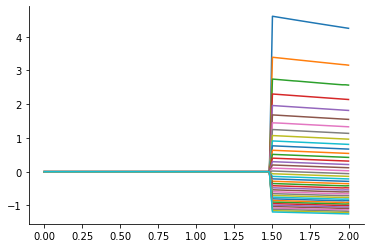

In [477]:
plt.plot(y_grid_cap,ϕ_ref.T)
plt.show()

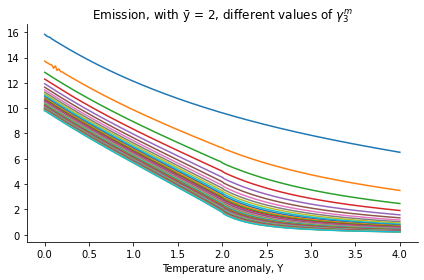

In [478]:
for i in range(len(dmg_weight)):
    plt.plot(y_grid,ems_list[-1, i, :])
plt.xlabel('Temperature anomaly, Y')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

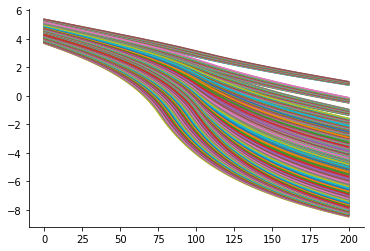

In [20]:
for i in range(len(res_list)):
    plt.plot(res_list[i]['φ'])

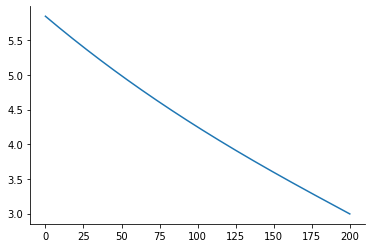

In [21]:
plt.plot(solution_low['φ'])

In [55]:
ϕ_ref.shape

(40, 101)

In [56]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

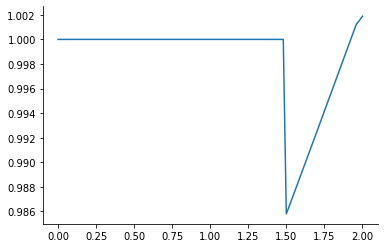

In [77]:
plt.plot(y_grid_cap, weighted)

In [24]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.4

In [25]:
r0, r1

(-0.4, -19.5000916299522)

In [26]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [27]:
ϕ_low = solution_low['φ']
ϕ_list_no_low = np.zeros((len(γ3_list[1:]), len(ϕ_low)))
for i in range(len(γ3_list[1:])):
    ϕ_list_no_low[i] = res_list[-(len(γ3_list[1:]) - i)]['φ']

In [28]:
ϕ_list_no_low.shape

(39, 201)

In [484]:
ϕ_list2 = np.concatenate(([ϕ_low], ϕ_list_no_low), axis=0)

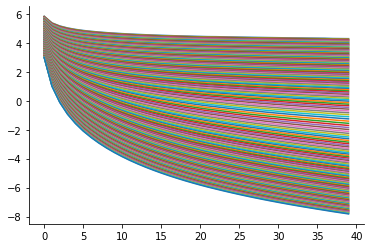

In [486]:
plt.plot(ϕ_list2)
plt.show()

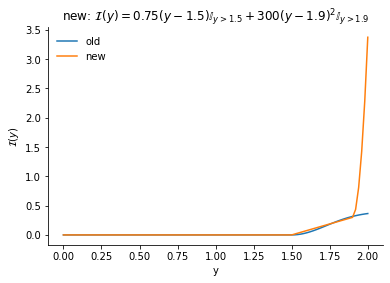

In [690]:
# plt.plot(y_grid_cap,3*intensity, label="x3")
# plt.plot(y_grid_cap,10*intensity, label="x10")
y_lower=1.5
intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
plt.plot(y_grid_cap, intensity, label="old")
y_lower=1.5
I = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)

# plt.plot(y_grid_cap, I, label="1.5")
y_lower=1.4
IO = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, IO, label="1.4")

func = 3/(y_bar - y_lower)**2*(y_grid_cap - y_lower)**2*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, func, label="test 1.4")

func1 = 3/(y_bar - 1.5)**2*(y_grid_cap -1.5)**2*(y_grid_cap >= 1.5)
# plt.plot(y_grid_cap, func1, label="test 1.5")

func2 = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)
plt.plot(y_grid_cap, func2, label="new")

plt.title(r"new: $\mathcal{I}(y) = 0.75(y - 1.5)\mathbb{I}_{y>1.5} + 300(y - 1.9)^2\mathbb{I}_{y > 1.9}$")
plt.xlabel('y')
plt.ylabel(r"$\mathcal{I}(y)$")
plt.legend(frameon=False)
# plt.savefig('intensity.png',dpi=500, facecolor="w", edgecolor="w")

In [668]:
0.3/(1.9-1.5)

0.7500000000000001

In [488]:
y_lower=1.5
r0*(np.exp(r1/2*(1.9- y_lower)**2)-1)*(1.9 >= y_lower)

0.31594618766969684

In [750]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_ref[i])) for i in range(len(γ3_list))])
    g_list[g_list<1e-15] = 1e-15
    
    ϕ_group = np.concatenate([[ϕ],ϕ_ref], axis=0)
    ϕ_max = np.max(ϕ_group, axis=0)
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*ϕ_ref))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.005360756186020095,	 ft error: 0.005536571344278096
episode: 2,	 ode error: 0.0019477918194748846,	 ft error: 0.002312404173970606
episode: 3,	 ode error: 0.001394316995440941,	 ft error: 0.0018496854341285007
episode: 4,	 ode error: 0.0012717654610914994,	 ft error: 0.0016828563826021825
episode: 5,	 ode error: 0.0012110605555733615,	 ft error: 0.001638935649017348
episode: 6,	 ode error: 0.0011759779302908287,	 ft error: 0.0016260802558423215
episode: 7,	 ode error: 0.0011452372966026525,	 ft error: 0.0015960201936198182
episode: 8,	 ode error: 0.0011162512140727374,	 ft error: 0.0015655348070259256
episode: 9,	 ode error: 0.001093641386481832,	 ft error: 0.0014628123055602238
episode: 10,	 ode error: 0.0012852118873526892,	 ft error: 0.001499629285807158
episode: 11,	 ode error: 0.0015234128156648707,	 ft error: 0.0016775562477526762
episode: 12,	 ode error: 0.001757930448404492,	 ft error: 0.0019142227764995523
episode: 13,	 ode error: 0.001988945006759904

episode: 161,	 ode error: 0.013258892862633674,	 ft error: 0.01330354946996204
episode: 162,	 ode error: 0.013234197027588879,	 ft error: 0.013274534367597512
episode: 163,	 ode error: 0.013208146387319986,	 ft error: 0.013277979117720884
episode: 164,	 ode error: 0.013182318928522438,	 ft error: 0.013252019482001831
episode: 165,	 ode error: 0.013155710820682669,	 ft error: 0.013227767176969163
episode: 166,	 ode error: 0.013128066936392124,	 ft error: 0.013237363417829773
episode: 167,	 ode error: 0.013100185348009004,	 ft error: 0.013170197306399567
episode: 168,	 ode error: 0.013071582157500865,	 ft error: 0.01314149141502785
episode: 169,	 ode error: 0.013042265053849783,	 ft error: 0.013111906693646258
episode: 170,	 ode error: 0.013012765155174195,	 ft error: 0.013032231050176035
episode: 171,	 ode error: 0.012981432019713593,	 ft error: 0.013000423326254174
episode: 172,	 ode error: 0.012949085336923079,	 ft error: 0.013011957303600719
episode: 173,	 ode error: 0.01291716941645

episode: 327,	 ode error: 0.00563263936976352,	 ft error: 0.0056665175301473525
episode: 328,	 ode error: 0.005590884602740251,	 ft error: 0.005626399326376319
episode: 329,	 ode error: 0.005549290328205531,	 ft error: 0.005586723404586547
episode: 330,	 ode error: 0.005507871072839135,	 ft error: 0.005547254277722846
episode: 331,	 ode error: 0.005466633163179489,	 ft error: 0.005508188427681304
episode: 332,	 ode error: 0.005425572114860888,	 ft error: 0.005469726007206077
episode: 333,	 ode error: 0.005384679567651596,	 ft error: 0.0054320075666445256
episode: 334,	 ode error: 0.005343945546860733,	 ft error: 0.0053951999520673866
episode: 335,	 ode error: 0.005303357460924418,	 ft error: 0.005359527273792519
episode: 336,	 ode error: 0.005263317659408552,	 ft error: 0.00528340264769156
episode: 337,	 ode error: 0.005223850871400086,	 ft error: 0.005243426166495979
episode: 338,	 ode error: 0.0051841711455028056,	 ft error: 0.005237483216168126
episode: 339,	 ode error: 0.0051443433

episode: 500,	 ode error: 0.001339047590826592,	 ft error: 0.0013369876565949568
episode: 501,	 ode error: 0.0013308273837691204,	 ft error: 0.001291590155164446
episode: 502,	 ode error: 0.0012748306630035178,	 ft error: 0.0012798810423126916
episode: 503,	 ode error: 0.0012629752797478702,	 ft error: 0.0013090697227138293
episode: 504,	 ode error: 0.00129903592652085,	 ft error: 0.0012920268277016866
episode: 505,	 ode error: 0.0013017869761030448,	 ft error: 0.0012447256427923215
episode: 506,	 ode error: 0.0012284574424001951,	 ft error: 0.0012334303400138857
episode: 507,	 ode error: 0.00121740482946215,	 ft error: 0.001221914475904029
episode: 508,	 ode error: 0.001206025114932334,	 ft error: 0.0012501142575667146
episode: 509,	 ode error: 0.0011944010577280145,	 ft error: 0.0012307281443777462
episode: 510,	 ode error: 0.0012166307854081376,	 ft error: 0.001188460365747268
episode: 511,	 ode error: 0.0011729275126147534,	 ft error: 0.001177675967792613
episode: 512,	 ode error: 

episode: 656,	 ode error: 0.0004236619798158592,	 ft error: 0.0003238665722204992
episode: 657,	 ode error: 0.0004326663491080879,	 ft error: 0.0003511832494123013
episode: 658,	 ode error: 0.0003295693566764263,	 ft error: 0.0003251089063258661
episode: 659,	 ode error: 0.00032613378672143034,	 ft error: 0.00032170557456057125
episode: 660,	 ode error: 0.00041825570385124744,	 ft error: 0.00031336002540838237
episode: 661,	 ode error: 0.000428623351626814,	 ft error: 0.00034117259388555254
episode: 662,	 ode error: 0.00031878631241623323,	 ft error: 0.0003146683314012577
episode: 663,	 ode error: 0.0003155858254917515,	 ft error: 0.0003113595536672342
episode: 664,	 ode error: 0.00041373897656461767,	 ft error: 0.00030332900694496345
episode: 665,	 ode error: 0.00042552240793911067,	 ft error: 0.0003317542328149514
episode: 666,	 ode error: 0.00030851717088420383,	 ft error: 0.0003047749413580547
episode: 667,	 ode error: 0.0003047475224709356,	 ft error: 0.0002982310338826011
episode

episode: 827,	 ode error: 9.580280816368081e-05,	 ft error: 8.119937560380208e-05
episode: 828,	 ode error: 0.00011264210937562968,	 ft error: 7.09626414128195e-05
episode: 829,	 ode error: 0.00016908396050192842,	 ft error: 0.00010636376981310036
episode: 830,	 ode error: 9.585930722175173e-05,	 ft error: 8.824497962844902e-05
episode: 831,	 ode error: 9.404554378900087e-05,	 ft error: 8.129499428388698e-05
episode: 832,	 ode error: 0.00019107838651205578,	 ft error: 7.251230450933122e-05
episode: 833,	 ode error: 0.0001954569924426941,	 ft error: 0.00010872071003564798
episode: 834,	 ode error: 9.257042761634526e-05,	 ft error: 8.606278675493684e-05
episode: 835,	 ode error: 9.117816276221768e-05,	 ft error: 7.837282293188252e-05
episode: 836,	 ode error: 0.00019120160883602522,	 ft error: 7.275525224326174e-05
episode: 837,	 ode error: 0.00020543438838355188,	 ft error: 0.00010889940380742757
episode: 838,	 ode error: 9.010180054186412e-05,	 ft error: 8.495775798511573e-05
episode: 

episode: 1001,	 ode error: 4.757891594608932e-05,	 ft error: 4.041573076207783e-05
episode: 1002,	 ode error: 4.7476012606378903e-05,	 ft error: 3.9140863268727344e-05
episode: 1003,	 ode error: 5.8697405680138703e-05,	 ft error: 2.3707365653713453e-05
episode: 1004,	 ode error: 0.0001199294269902812,	 ft error: 5.855579603597505e-05
episode: 1005,	 ode error: 4.9099968086704915e-05,	 ft error: 4.129760746263145e-05
episode: 1006,	 ode error: 4.7660478069741496e-05,	 ft error: 5.9803838840188916e-05
episode: 1007,	 ode error: 0.00014468745363833968,	 ft error: 2.6765279668161668e-05
episode: 1008,	 ode error: 0.00014846253179115476,	 ft error: 6.284039751669468e-05
episode: 1009,	 ode error: 4.7656093147566136e-05,	 ft error: 4.097647456013931e-05
episode: 1010,	 ode error: 4.6667556021923184e-05,	 ft error: 5.7984850085013306e-05
episode: 1011,	 ode error: 0.00014618013646205963,	 ft error: 2.8782813727978862e-05
episode: 1012,	 ode error: 0.00016044239438853247,	 ft error: 6.49075317

episode: 1177,	 ode error: 4.035638771257566e-05,	 ft error: 3.552733965861421e-05
episode: 1178,	 ode error: 3.9131472566136805e-05,	 ft error: 3.2132592165723395e-05
episode: 1179,	 ode error: 3.9256264866172064e-05,	 ft error: 4.7569713199635544e-05
episode: 1180,	 ode error: 5.492791521262419e-05,	 ft error: 2.9923301884338116e-05
episode: 1181,	 ode error: 0.00011524391422858271,	 ft error: 5.134075345747391e-05
episode: 1182,	 ode error: 4.154934128447474e-05,	 ft error: 3.388465901643656e-05
episode: 1183,	 ode error: 3.949298816460778e-05,	 ft error: 3.1509398914941755e-05
episode: 1184,	 ode error: 3.827915524447223e-05,	 ft error: 5.7383130240395985e-05
episode: 1185,	 ode error: 0.0001746636648955191,	 ft error: 5.934695574794091e-05
episode: 1186,	 ode error: 4.052184598914155e-05,	 ft error: 2.541409825429497e-05
episode: 1187,	 ode error: 3.8398595782154765e-05,	 ft error: 7.579909052068956e-05
episode: 1188,	 ode error: 6.18006097467122e-05,	 ft error: 3.8877529171088554

episode: 1337,	 ode error: 5.760398721990634e-05,	 ft error: 8.626592270744027e-06
episode: 1338,	 ode error: 3.9147739968978246e-05,	 ft error: 2.2305263907895778e-05
episode: 1339,	 ode error: 3.746027532523788e-05,	 ft error: 2.155390324087847e-05
episode: 1340,	 ode error: 4.575993845276627e-05,	 ft error: 2.488735587569124e-05
episode: 1341,	 ode error: 3.517570920213986e-05,	 ft error: 2.2496560247553532e-05
episode: 1342,	 ode error: 3.355072497657208e-05,	 ft error: 2.1130344852515748e-05
episode: 1343,	 ode error: 3.351567253358223e-05,	 ft error: 9.257336859125331e-05
episode: 1344,	 ode error: 5.849031071117339e-05,	 ft error: 7.3974261169951205e-06
episode: 1345,	 ode error: 3.984395638582938e-05,	 ft error: 2.6418418177520664e-05
episode: 1346,	 ode error: 3.789414208618669e-05,	 ft error: 2.4250322138819058e-05
episode: 1347,	 ode error: 5.0654498830043915e-05,	 ft error: 2.6345987976128526e-05
episode: 1348,	 ode error: 3.619347237829307e-05,	 ft error: 2.370709188070918

episode: 1466,	 ode error: 0.00014389209361666266,	 ft error: 3.348586594054126e-05
episode: 1467,	 ode error: 0.0001594926288094184,	 ft error: 5.996104177707906e-05
episode: 1468,	 ode error: 4.043827375357911e-05,	 ft error: 3.593625525954991e-05
episode: 1469,	 ode error: 3.927059048414172e-05,	 ft error: 3.235371646592711e-05
episode: 1470,	 ode error: 3.940798991902694e-05,	 ft error: 4.854772519369277e-05
episode: 1471,	 ode error: 5.646779443593819e-05,	 ft error: 2.851829983185894e-05
episode: 1472,	 ode error: 0.00011445145048918914,	 ft error: 5.12283014666437e-05
episode: 1473,	 ode error: 4.13304284489352e-05,	 ft error: 3.3701517489603816e-05
episode: 1474,	 ode error: 4.007962739925597e-05,	 ft error: 6.748573785930745e-05
episode: 1475,	 ode error: 0.0001387004468873243,	 ft error: 2.85986430199614e-05
episode: 1476,	 ode error: 0.00014343265662776494,	 ft error: 5.588166481018675e-05
episode: 1477,	 ode error: 4.0346495857629394e-05,	 ft error: 3.3885644411313365e-05
e

episode: 1597,	 ode error: 6.15877958545924e-05,	 ft error: 1.6610231154068344e-05
episode: 1598,	 ode error: 6.055681660302459e-05,	 ft error: 1.8343309281299014e-05
episode: 1599,	 ode error: 6.176648088382364e-05,	 ft error: 2.2785807443526096e-05
episode: 1600,	 ode error: 6.455846128824994e-05,	 ft error: 2.7070571233522855e-05
episode: 1601,	 ode error: 6.79208644927265e-05,	 ft error: 3.1566467758814554e-05
episode: 1602,	 ode error: 7.153774695010939e-05,	 ft error: 3.683726956715816e-05
episode: 1603,	 ode error: 7.558364125484496e-05,	 ft error: 4.320499169985226e-05
episode: 1604,	 ode error: 8.031015564577415e-05,	 ft error: 5.104232360064742e-05
episode: 1605,	 ode error: 9.730291269234581e-05,	 ft error: 6.101109711309505e-05
episode: 1606,	 ode error: 0.00012910416583276907,	 ft error: 5.443032896135236e-05
episode: 1607,	 ode error: 4.5258766234165804e-05,	 ft error: 2.6184088312675158e-05
episode: 1608,	 ode error: 2.8661191590659274e-05,	 ft error: 7.406608408278004e-

episode: 1770,	 ode error: 4.018519903890849e-05,	 ft error: 3.295290028315634e-05
episode: 1771,	 ode error: 3.9115389301694337e-05,	 ft error: 6.844466568267649e-05
episode: 1772,	 ode error: 0.00013792197286836838,	 ft error: 2.917001298641253e-05
episode: 1773,	 ode error: 0.00014287054278185052,	 ft error: 5.6134936706087046e-05
episode: 1774,	 ode error: 3.9655345518030405e-05,	 ft error: 3.381319068029853e-05
episode: 1775,	 ode error: 3.893153001201244e-05,	 ft error: 6.647807308279852e-05
episode: 1776,	 ode error: 0.000140692662023309,	 ft error: 3.323041738845234e-05
episode: 1777,	 ode error: 0.00015543424566850927,	 ft error: 5.868895584448808e-05
episode: 1778,	 ode error: 3.970458645971564e-05,	 ft error: 3.508642100147341e-05
episode: 1779,	 ode error: 3.850716867363768e-05,	 ft error: 3.1570061876706745e-05
episode: 1780,	 ode error: 3.865668005460787e-05,	 ft error: 4.875859901698476e-05
episode: 1781,	 ode error: 5.5801230017721304e-05,	 ft error: 3.0213599812256575e

episode: 1940,	 ode error: 4.1235727404678735e-05,	 ft error: 2.3169386442312145e-05
episode: 1941,	 ode error: 3.9805956578500834e-05,	 ft error: 4.0135246530681457e-05
episode: 1942,	 ode error: 6.351435211379708e-05,	 ft error: 3.1620114159913726e-05
episode: 1943,	 ode error: 3.7774568504872486e-05,	 ft error: 2.560229224357613e-05
episode: 1944,	 ode error: 3.603307139977974e-05,	 ft error: 2.3812766333897173e-05
episode: 1945,	 ode error: 3.485002380908264e-05,	 ft error: 3.302789856896027e-05
episode: 1946,	 ode error: 3.8941463440925195e-05,	 ft error: 1.9357078778980963e-05
episode: 1947,	 ode error: 4.254017376525976e-05,	 ft error: 5.620106563153371e-05
episode: 1948,	 ode error: 5.594634044783775e-05,	 ft error: 6.476451111847581e-05
episode: 1949,	 ode error: 6.964641226321622e-05,	 ft error: 4.911780673566568e-05
episode: 1950,	 ode error: 3.668289940035596e-05,	 ft error: 2.893820493721222e-05
episode: 1951,	 ode error: 3.554568429924021e-05,	 ft error: 1.949193320882614

episode: 2113,	 ode error: 0.00019152492749212324,	 ft error: 1.5109294125181805e-05
episode: 2114,	 ode error: 0.00019163767469658477,	 ft error: 1.727154505815065e-05
episode: 2115,	 ode error: 0.00020886840244738192,	 ft error: 4.361250037288045e-05
episode: 2116,	 ode error: 4.944769259926374e-05,	 ft error: 3.936492696432481e-05
episode: 2117,	 ode error: 0.00019822570607913592,	 ft error: 1.152843412643989e-05
episode: 2118,	 ode error: 0.0001990243224922611,	 ft error: 1.4352547701435014e-05
episode: 2119,	 ode error: 0.00021979290062498769,	 ft error: 4.426006236535329e-05
episode: 2120,	 ode error: 4.897301311661273e-05,	 ft error: 2.7011034486434937e-05
episode: 2121,	 ode error: 2.7215122915341672e-05,	 ft error: 3.5360629727421156e-05
episode: 2122,	 ode error: 0.00017066359438566714,	 ft error: 3.5418255341923555e-06
episode: 2123,	 ode error: 0.00016778033420949967,	 ft error: 9.004444233795539e-06
episode: 2124,	 ode error: 0.00019560126522978616,	 ft error: 1.1855613244

episode: 2274,	 ode error: 7.752305177069485e-05,	 ft error: 3.460820323120117e-05
episode: 2275,	 ode error: 3.566285909022138e-05,	 ft error: 2.268112726255822e-05
episode: 2276,	 ode error: 3.410766519323927e-05,	 ft error: 2.0266907472255014e-05
episode: 2277,	 ode error: 3.2955402206172324e-05,	 ft error: 2.0751275960684268e-05
episode: 2278,	 ode error: 3.263998676628077e-05,	 ft error: 9.091820322737476e-05
episode: 2279,	 ode error: 5.91842825160005e-05,	 ft error: 1.1679500109273988e-05
episode: 2280,	 ode error: 3.864480776519241e-05,	 ft error: 2.5985077127366196e-05
episode: 2281,	 ode error: 3.6660057925588796e-05,	 ft error: 6.207933941126953e-06
episode: 2282,	 ode error: 3.7302078564907526e-05,	 ft error: 2.5012979878447084e-05
episode: 2283,	 ode error: 3.36163169395165e-05,	 ft error: 2.1458971912302616e-05
episode: 2284,	 ode error: 3.341635977201218e-05,	 ft error: 9.032307837220088e-05
episode: 2285,	 ode error: 5.790311696846073e-05,	 ft error: 6.336706371179446e-

episode: 2456,	 ode error: 0.00015890029749097978,	 ft error: 5.9953848517757535e-05
episode: 2457,	 ode error: 3.983114393334153e-05,	 ft error: 2.5265702042531757e-05
episode: 2458,	 ode error: 3.460327427147469e-05,	 ft error: 2.6749280441329404e-05
episode: 2459,	 ode error: 3.2821312307071415e-05,	 ft error: 5.628190156237167e-05
episode: 2460,	 ode error: 0.000173966745932147,	 ft error: 4.254700121197885e-05
episode: 2461,	 ode error: 5.0945545635575074e-05,	 ft error: 2.833533086388229e-05
episode: 2462,	 ode error: 3.184854828790218e-05,	 ft error: 8.86333938874273e-05
episode: 2463,	 ode error: 7.189283344589958e-05,	 ft error: 3.515923959795941e-05
episode: 2464,	 ode error: 3.663577944566787e-05,	 ft error: 2.5121639390945916e-05
episode: 2465,	 ode error: 3.135655397225323e-05,	 ft error: 7.9439571094575e-05
episode: 2466,	 ode error: 0.00016591496722270782,	 ft error: 4.751419731263695e-05
episode: 2467,	 ode error: 4.890513426498988e-05,	 ft error: 3.116080712572966e-05


episode: 2631,	 ode error: 6.272057527255404e-05,	 ft error: 1.7030691907393702e-05
episode: 2632,	 ode error: 6.19766420324186e-05,	 ft error: 1.9174692389434256e-05
episode: 2633,	 ode error: 6.358413563430088e-05,	 ft error: 2.9025719885389378e-05
episode: 2634,	 ode error: 0.000157459716526559,	 ft error: 4.275837831535512e-05
episode: 2635,	 ode error: 7.980719961188376e-05,	 ft error: 3.382095440152e-05
episode: 2636,	 ode error: 7.769161690249216e-05,	 ft error: 3.548300956524031e-05
episode: 2637,	 ode error: 7.827749818942187e-05,	 ft error: 3.9230023938685576e-05
episode: 2638,	 ode error: 8.055579953707148e-05,	 ft error: 4.3761335411396374e-05
episode: 2639,	 ode error: 8.370707590654725e-05,	 ft error: 4.90887217363678e-05
episode: 2640,	 ode error: 8.75677666049568e-05,	 ft error: 5.5644369800766924e-05
episode: 2641,	 ode error: 9.956940998993857e-05,	 ft error: 6.381505736996473e-05
episode: 2642,	 ode error: 0.0001268509782026972,	 ft error: 5.939153124145946e-05
episo

episode: 2805,	 ode error: 0.0001310212518590287,	 ft error: 7.03512010504781e-05
episode: 2806,	 ode error: 3.415315747794245e-05,	 ft error: 4.017198870798211e-05
episode: 2807,	 ode error: 3.3679239953968154e-05,	 ft error: 6.502485764681154e-05
episode: 2808,	 ode error: 0.00010784155824163089,	 ft error: 2.2169127621651796e-05
episode: 2809,	 ode error: 0.0001109607586828043,	 ft error: 4.1169166530075074e-05
episode: 2810,	 ode error: 0.0001455929813978657,	 ft error: 6.988623120740556e-05
episode: 2811,	 ode error: 3.965422564521093e-05,	 ft error: 4.1514215560312095e-05
episode: 2812,	 ode error: 3.89147505670262e-05,	 ft error: 6.478693797706825e-05
episode: 2813,	 ode error: 0.00012718530560730523,	 ft error: 2.4033987847005278e-05
episode: 2814,	 ode error: 0.00013210734678309466,	 ft error: 6.346660190192921e-05
episode: 2815,	 ode error: 4.215418750061484e-05,	 ft error: 4.001260275732221e-05
episode: 2816,	 ode error: 4.1249869292409036e-05,	 ft error: 5.972717857449794e-

episode: 2986,	 ode error: 3.421191230718046e-05,	 ft error: 1.8760807523499068e-05
episode: 2987,	 ode error: 3.4250319158782294e-05,	 ft error: 2.850271680987504e-05
episode: 2988,	 ode error: 9.968539022611744e-05,	 ft error: 5.2992008664709545e-05
episode: 2989,	 ode error: 0.0001177065511155373,	 ft error: 3.444535034269336e-05
episode: 2990,	 ode error: 4.520645900669973e-05,	 ft error: 2.00503951370834e-05
episode: 2991,	 ode error: 3.379528902452966e-05,	 ft error: 2.0243985469292625e-05
episode: 2992,	 ode error: 3.188914242649443e-05,	 ft error: 2.039262977771017e-05
episode: 2993,	 ode error: 3.0254920712027844e-05,	 ft error: 1.669331696962928e-05
episode: 2994,	 ode error: 3.187828915043878e-05,	 ft error: 5.5907505916330535e-05
episode: 2995,	 ode error: 5.099047533557721e-05,	 ft error: 2.136573399180719e-05
episode: 2996,	 ode error: 3.464263626584696e-05,	 ft error: 2.030474348391209e-05
episode: 2997,	 ode error: 3.184746725629073e-05,	 ft error: 2.6098645233396667e-0

episode: 3166,	 ode error: 3.943399639858014e-05,	 ft error: 6.617070856673735e-05
episode: 3167,	 ode error: 5.34936148654519e-05,	 ft error: 3.6657028292808036e-05
episode: 3168,	 ode error: 4.1366290207303646e-05,	 ft error: 2.9817185407843283e-05
episode: 3169,	 ode error: 3.9351604939272256e-05,	 ft error: 2.6506269797721416e-05
episode: 3170,	 ode error: 3.8079008909286394e-05,	 ft error: 2.2907757061041423e-05
episode: 3171,	 ode error: 3.915497314556371e-05,	 ft error: 2.462709840767019e-05
episode: 3172,	 ode error: 5.8049031578605303e-05,	 ft error: 4.408028114610829e-05
episode: 3173,	 ode error: 6.027253927989862e-05,	 ft error: 3.434297544924192e-05
episode: 3174,	 ode error: 3.9855138258673706e-05,	 ft error: 2.6380221470390097e-05
episode: 3175,	 ode error: 3.7545635950930745e-05,	 ft error: 2.4788071019798963e-05
episode: 3176,	 ode error: 3.573975626210146e-05,	 ft error: 2.3005829849154225e-05
episode: 3177,	 ode error: 3.544983688391623e-05,	 ft error: 8.817784713865

episode: 3334,	 ode error: 0.0001237421185013715,	 ft error: 2.33389567663167e-05
episode: 3335,	 ode error: 0.0001331829959813069,	 ft error: 6.69760753924109e-05
episode: 3336,	 ode error: 4.490569922777077e-05,	 ft error: 4.2040300861856394e-05
episode: 3337,	 ode error: 4.412599152679719e-05,	 ft error: 5.649792577866464e-05
episode: 3338,	 ode error: 0.00011618901428091244,	 ft error: 1.944777116147378e-05
episode: 3339,	 ode error: 0.00012437472070249422,	 ft error: 6.36089010193075e-05
episode: 3340,	 ode error: 4.530326842916432e-05,	 ft error: 4.058038355392313e-05
episode: 3341,	 ode error: 4.4244448231700595e-05,	 ft error: 5.459996641654641e-05
episode: 3342,	 ode error: 0.0001136795817991143,	 ft error: 1.8895731713541863e-05
episode: 3343,	 ode error: 0.0001215610847518922,	 ft error: 6.152606011866624e-05
episode: 3344,	 ode error: 4.49325049022703e-05,	 ft error: 3.92852210024941e-05
episode: 3345,	 ode error: 4.3757134360264405e-05,	 ft error: 5.483258955507608e-05
epi

episode: 3514,	 ode error: 2.8543762475546908e-05,	 ft error: 1.8023353081986215e-05
episode: 3515,	 ode error: 2.7526677909964214e-05,	 ft error: 1.6153149879016837e-05
episode: 3516,	 ode error: 2.803302897154414e-05,	 ft error: 9.356836802520974e-05
episode: 3517,	 ode error: 6.216133348217745e-05,	 ft error: 8.550584242428272e-06
episode: 3518,	 ode error: 3.9739204137412276e-05,	 ft error: 2.8991194382932406e-05
episode: 3519,	 ode error: 3.257789986883808e-05,	 ft error: 1.9941281627744445e-05
episode: 3520,	 ode error: 4.098411030291349e-05,	 ft error: 2.3705930920492335e-05
episode: 3521,	 ode error: 3.061954526455135e-05,	 ft error: 1.928507736526086e-05
episode: 3522,	 ode error: 2.8950345726919124e-05,	 ft error: 2.8177702205312016e-05
episode: 3523,	 ode error: 3.9704899493675505e-05,	 ft error: 1.8575738453208146e-05
episode: 3524,	 ode error: 4.105307319043905e-05,	 ft error: 6.174395774127817e-05
episode: 3525,	 ode error: 5.76301776258753e-05,	 ft error: 2.8738021693008

episode: 3695,	 ode error: 2.6379552708982734e-05,	 ft error: 9.307239645917065e-05
episode: 3696,	 ode error: 0.0001638855984426868,	 ft error: 6.248880523695988e-05
episode: 3697,	 ode error: 4.2773333677387226e-05,	 ft error: 4.0503994540586064e-05
episode: 3698,	 ode error: 4.402192090399715e-05,	 ft error: 1.8932656502101963e-05
episode: 3699,	 ode error: 2.7401271828389473e-05,	 ft error: 7.777584792467707e-05
episode: 3700,	 ode error: 7.22879818137595e-05,	 ft error: 2.5359716537387555e-05
episode: 3701,	 ode error: 3.730001879102829e-05,	 ft error: 1.4556352698313901e-05
episode: 3702,	 ode error: 3.230372359969147e-05,	 ft error: 1.972039508046919e-05
episode: 3703,	 ode error: 2.9807283384822303e-05,	 ft error: 2.1235320083690112e-05
episode: 3704,	 ode error: 2.859042124346567e-05,	 ft error: 9.519129677482141e-05
episode: 3705,	 ode error: 6.168776725450076e-05,	 ft error: 7.760008674750907e-06
episode: 3706,	 ode error: 4.1422046337419305e-05,	 ft error: 4.883697556046229

episode: 3876,	 ode error: 0.0001757261866875276,	 ft error: 8.911818066614785e-06
episode: 3877,	 ode error: 0.00017010231289615874,	 ft error: 1.2927380594440763e-05
episode: 3878,	 ode error: 0.00019350526992903405,	 ft error: 1.4952546949942302e-05
episode: 3879,	 ode error: 0.00021679421384715458,	 ft error: 3.780972062905619e-05
episode: 3880,	 ode error: 4.9567714046419575e-05,	 ft error: 2.0632222755168073e-05
episode: 3881,	 ode error: 2.781998552622844e-05,	 ft error: 3.3536221160979096e-05
episode: 3882,	 ode error: 0.0001297626624843229,	 ft error: 1.4654679770131906e-05
episode: 3883,	 ode error: 0.00018516092473394585,	 ft error: 1.2738279514756812e-05
episode: 3884,	 ode error: 0.0002125624505927709,	 ft error: 3.9844919620612984e-05
episode: 3885,	 ode error: 4.823060260902845e-05,	 ft error: 2.0101830886076755e-05
episode: 3886,	 ode error: 2.7240330870578755e-05,	 ft error: 3.142026471980586e-05
episode: 3887,	 ode error: 0.00010036150955143597,	 ft error: 2.646492669

In [751]:
weighted, ϕ_new, g_list[:,-1]

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

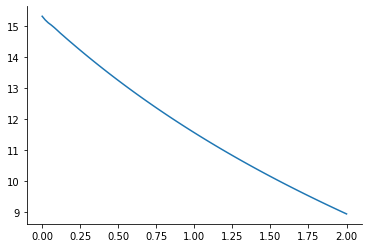

In [752]:
plt.plot(y_grid_cap,ems)

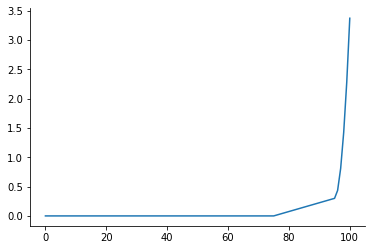

In [753]:
plt.plot(intensity)

In [754]:
r0, y_bar, y_lower

(-0.4, 2, 1.4)

In [812]:

def no_jump_simulation():
    y = 1.1
    T = 120
    dt = 1
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            yt[t] = y
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [814]:
def no_jump_simulation_long(ems):
    y = 1.1
    T = 100
    dt = 1
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [815]:
et, yt, probt = no_jump_simulation()

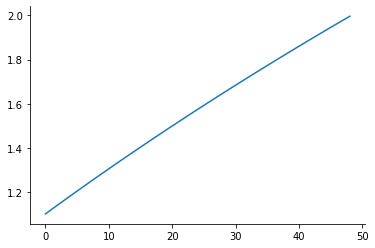

In [816]:
plt.plot(yt)

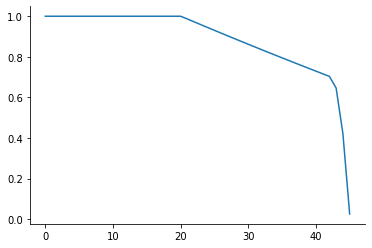

In [817]:
# year = np.arange(0, T-τ, τ)
plt.plot(probt)
# plt.ylim(0)

In [818]:
len(ems_list), jump_interval[-1]

(26, 2.0000000000000004)

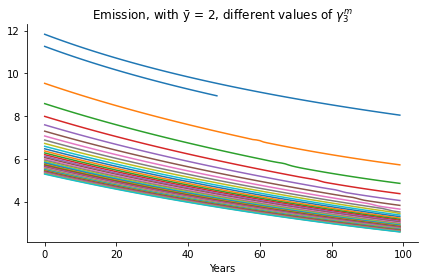

In [898]:
et_tests = []
for i in range(len(dmg_weight)):
    et_test, _, _ = no_jump_simulation_long(ems_list[-1, i])
    plt.plot(et_test)
    et_tests.append(et_test)
    
plt.plot(et)    
plt.xlabel('Years')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.xlim(0,3)
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

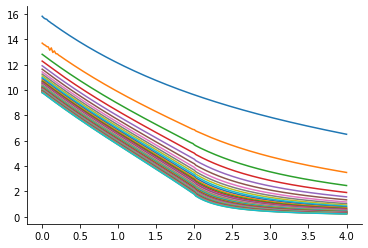

In [820]:
plt.plot(y_grid,ems_list[-1].T)
plt.show()

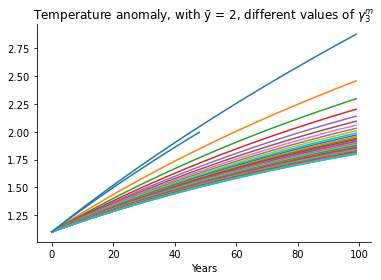

In [897]:
yt_refs = []
for i in range(len(dmg_weight)):
    _, yt_ref, _ = no_jump_simulation_long(ems_list[-1, i])
    plt.plot(yt_ref, label="$\gamma2$")
    yt_refs.append(yt_ref)

# plt.legend()    
plt.plot(yt)
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
fig.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

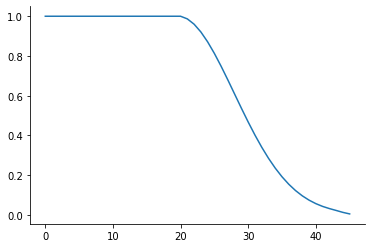

In [823]:
instensity = 1 - probt
integral = np.cumsum(instensity)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [883]:
prob_no_jump = np.cumprod(probt)
prob_no_jump.shape, yt.shape

((46,), (49,))

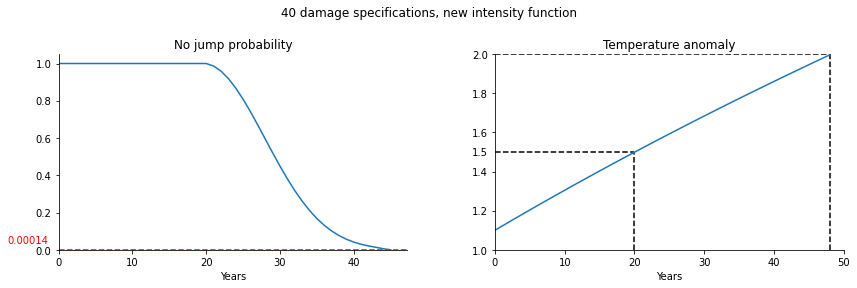

In [887]:
import matplotlib.transforms as transforms
T_jump = np.abs(yt-1.5).argmin()
T_stop = len(yt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('{} damage specifications, new intensity function'.format(len(dmg_weight)), y=0.99)
ax1.plot(prob_no_jump)
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")


ax2.plot(yt)
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop-1, color="black", linestyle="dashed")
ax2.vlines(T_stop-1, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, len(yt)+1) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax1.text(0,1.5, 1.5, color="black", transform=trans, 
        ha="right", va="center")

fig.tight_layout()

# fig.savefig('prob_anomaly_new.png',dpi=500, facecolor="w", edgecolor="w")

In [881]:
T_jump

20

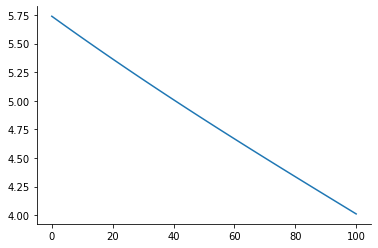

In [882]:
ϕ_list.shape
plt.plot(ϕ)

In [828]:
ϕ_list.shape, ems_list.shape

((26, 40, 201), (26, 40, 201))

In [836]:
def jump_simulation():
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
    ems_list = res_dict['ems_list']
    ϕ_list = res_dict['φ_list']
    y0 = 1.1
    y_lower = 1.5
    T = 100
    dt = 1
    T = int(T/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    T_extra = T - T_final
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        e_i = np.interp(y, y_grid_cap, ems)
#         prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)

        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        PROB[:, t] = prob_no[t]
        EMS[:, t] = et[t]
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        if t == T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt


            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                PROB[dmg+1, t] = intensity*dmg_weight[dmg]
                GS[dmg + 1, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[dmg+1,t]
                EMS[dmg+1, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[dmg+1, t] =  yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dmg_weight[dmg]
                GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg,loc+len(prepre_jump)]))*PROB[id_dmg, t]
                EMS[id_dmg, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = yt[t]
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
        
        for t in range(T_final, T+1):
            EMS[0, t] = EMS[0,t-1]
            probt[t] = 0
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = et[t-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
            for time in range(T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, PROB, GS, YS, EMS

In [837]:
solu = jump_simulation()

21


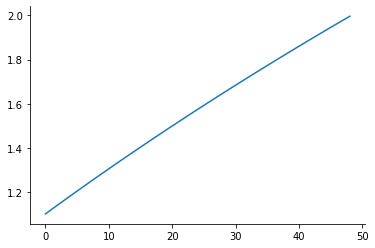

In [838]:
plt.plot(solu[1])

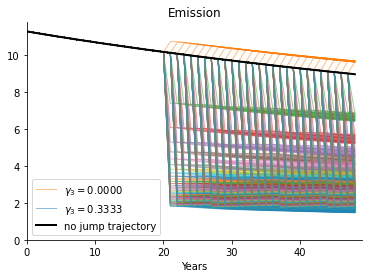

In [839]:
solu[-2][1], 
ems_test = solu[-1]

color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(ems_test[i, :len(yt)], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(solu[0])
plt.plot(et, color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
solu[-3][:,-1].sum()
# plt.plot(solu[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, len(solu[0]))
plt.legend()
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

In [840]:
ems_test.shape

(1121, 101)

(1.1, 3.2)

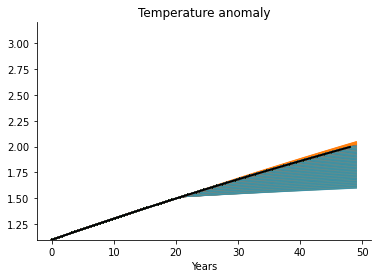

In [841]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :50], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

(1.1, 3.2)

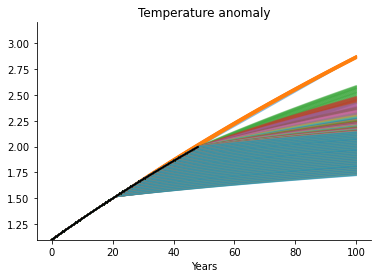

In [899]:
# 120
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :120], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [843]:
np.interp(3, y_grid_cap, ems_ref[0])

9.625855283479735

In [844]:
np.sum(solu[-4][:, len(yt)-1])

1.0

(0.0, 1.05)

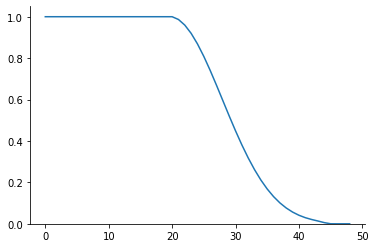

In [845]:
plt.plot(solu[3][:len(yt)])
plt.ylim(0)

In [846]:
solu[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.86620235e-01, 9.59498037e-01, 9.19647646e-01,
       8.68599778e-01, 8.08303932e-01, 7.41003829e-01, 6.69097170e-01,
       5.94992079e-01, 5.20972375e-01, 4.49082275e-01, 3.81038511e-01,
       3.18174484e-01, 2.61417578e-01, 2.11297411e-01, 1.67980150e-01,
       1.31322141e-01, 1.00935325e-01, 7.62570187e-02, 5.66175414e-02,
       4.13006355e-02, 2.95933207e-02, 2.08235674e-02, 1.34532022e-02,
       5.67198924e-03, 1.44171994e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [847]:
solu[3], solu[-2][1], solu[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = solu[-4][:,89]

prob_test.sum()

1.0

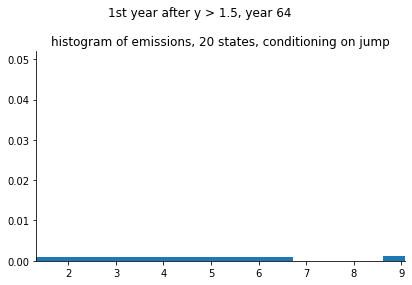

In [848]:
ems1 = solu[-1][:,65]
ems1 = ems1[np.nonzero(ems1)]
y1 = solu[-3][:,65]
y1 = y1[np.nonzero(y1)]
prob1 = solu[-2][:, 65]
prob1 = prob1[np.nonzero(prob1)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("1st year after y > 1.5, year 64")
axes.bar(ems1[1:], height=prob1[1:]/np.sum(prob1[1:]))
axes.set_xlim(np.min(ems1), np.max(ems1))
# axes[1].bar(y1[1:], height=prob1[1:]/np.sum(prob1[1:]))


axes.set_title("histogram of emissions, 20 states, conditioning on jump")
# axes[1].set_title("histogram of temperature anomaly, 20 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
axes.set_xlim(np.min(ems1), np.max(ems1))
# plt.savefig("histogram_1.png", facecolor="w", edgecolor="w")
plt.show()

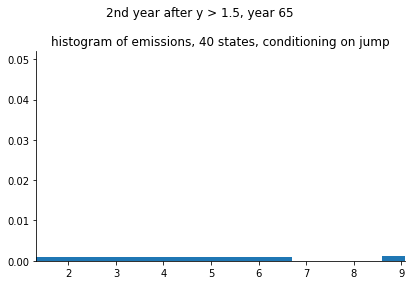

In [849]:
ems2 = solu[-1][:,66]
ems2 = ems2[np.nonzero(ems2)]
y2 = solu[-3][:, 66]
y2 = y2[np.nonzero(y2)]
prob2 = solu[-2][:, 66]
prob2 = prob2[np.nonzero(prob2)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("2nd year after y > 1.5, year 65")
axes.bar(ems2[1:], height=prob2[1:]/np.sum(prob2[1:]))
# axes[0].set_xlim(np.)
# axes.bar(y2[1:], prob2[1:]/np.sum(prob2[1:]) )
axes.set_xlim(np.min(ems1), np.max(ems1))
axes.set_title("histogram of emissions, 40 states, conditioning on jump")
# axes.set_title("histogram of temperature anomaly, 41 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
# axes[1].set_xlim(1.5, 1.8)
# plt.savefig("histogram_2.png", facecolor="w", edgecolor="w")
plt.show()

In [850]:
len(yt)

49

In [858]:
t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

In [859]:
y_110[0], yt[-1], prob_110.sum()

(1.996596260163385, 1.996596260163385, 1.0)

In [860]:
bins[np.nonzero(distribution)]

array([1.45777348, 1.86827155, 2.27876963, 2.6892677 , 3.09976577,
       3.51026385, 3.92076192, 4.33126   , 4.74175807, 5.15225615,
       5.56275422, 6.38375037, 6.79424844, 8.84673882, 9.25723689])

In [861]:
prob_110.shape, ems_110.shape

((1121,), (1121,))

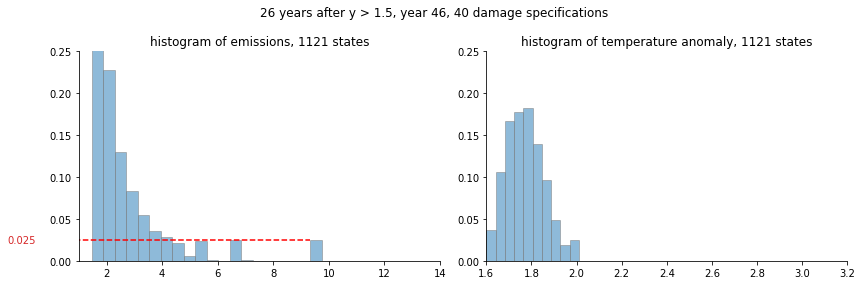

In [890]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
t = 46
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight))-2,t, len(dmg_weight)))
axes[0].hist(ems_110, weights=prob_110, bins=20, alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, bins=np.linspace(1.6, 3.2, 40), density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

p = axes[0].patches

distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.1,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")
# no jump
# axes[0].hlines(distribution[np.nonzero(distribution)][-2], 0, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# axes[0].text(-0.1,distribution[np.nonzero(distribution)][-2], "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="right", va="center")
axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6, 3.2)
axes[1].set_ylim(0,0.25)
axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("histogram_new.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

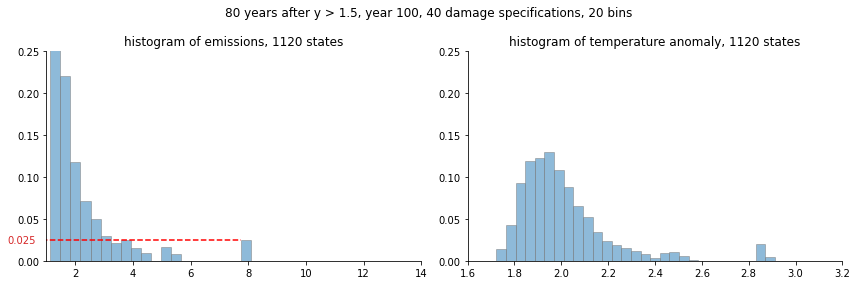

In [892]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-20, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

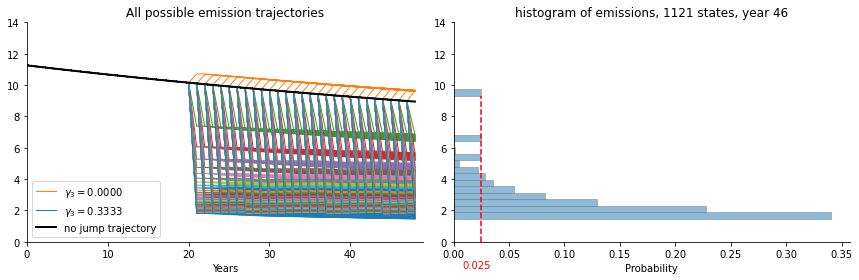

In [896]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

t = 46
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(ems_test[i, :len(yt)], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(solu[0])
ax1.plot(et, color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(solu[0]))
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, bins=20,
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
        ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,14)
ax1.set_ylim(0,14)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 46".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_new.png",facecolor="w", edgecolor="w", dpi=500)

In [296]:
p[-1].get_xy(), distribution

((0.0, 12.929800423113878),
 array([0.3861962 , 0.26626446, 0.12782639, 0.06918306, 0.04149067,
        0.02715704, 0.0226795 , 0.00243144, 0.02358719, 0.00115756,
        0.        , 0.        , 0.        , 0.02481983, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00720666]))

In [616]:
prob_110.shape, ems_110.shape

((1120,), (1121,))

In [172]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
prob = np.
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

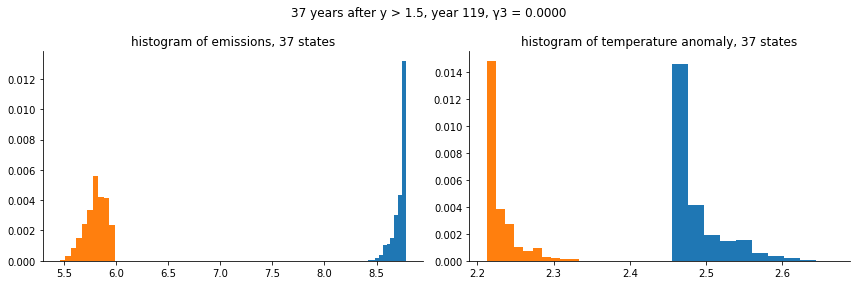

In [192]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
np.abs(distribution).argmax()

In [ ]:
bins[2], bins[3]

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')